In [1]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import mobilenet_v2
from sklearn.model_selection import train_test_split

In [2]:
dataset_dir = 'dataset'
images_dir = os.path.join(dataset_dir, 'images')
labels_csv = os.path.join(dataset_dir, 'labels.csv')

In [3]:
# Load the model if exists
model = None
if os.path.exists('model.keras'):
    model = tf.keras.models.load_model('model.keras')
    print("Model loaded successfully")

In [51]:
from sklearn.preprocessing import MultiLabelBinarizer

def cnn_model(input_shape):
    base_model = mobilenet_v2.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
    ])

    return model

def retrain_model(model, input_shape, classes):
    if model is None:
        model = cnn_model(input_shape)
    else:
        model.pop()

    model.add(layers.Dense(len(classes), activation='relu'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_model(model, train_data, train_labels, epochs):
    model.fit(train_data, train_labels, epochs=epochs)
    return model

def load_dataset(images_dir, labels_csv, input_shape):
    labels_df = pd.read_csv(labels_csv, sep=',')
    labels = labels_df.iloc[:, 1:].values
    images = []

    for img_name in labels_df.iloc[:, 0]:
        img_path = os.path.join(images_dir, img_name)
        img = keras.preprocessing.image.load_img(img_path, target_size=input_shape)
        img_array = keras.preprocessing.image.img_to_array(img)
        images.append(img_array)

    images = np.array(images)
    
    labels = [label.split(';') for label in labels_df.iloc[:, 1]]
    classes = sorted(set([item for sublist in labels for item in sublist]))
    mlb = MultiLabelBinarizer(classes=classes)
    labels = mlb.fit_transform(labels)
    return images, labels, classes

In [32]:
# Load dataset
data, labels, classes = load_dataset(images_dir, labels_csv, (224,224))
input_shape = data.shape[1:3] + (3,)
data = data / 255.0
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

In [52]:
# Retrain model or make a new one if missing
model = retrain_model(model, input_shape, classes)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 1024)              1311744   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 16)                16400     
                                                                 
Total params: 3586128 (13.68 MB)
Trainable params: 132

In [53]:
from tensorflow.keras.callbacks import EarlyStopping

# Define training settings
train_settings = {
    'epochs': 15,
    'callbacks': [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ],
    'validation_split': 0.2
}

# Train the model with the settings
history = model.fit(train_data, train_labels, epochs=train_settings['epochs'], 
                callbacks=train_settings['callbacks'], 
                validation_split=train_settings['validation_split'])

Epoch 1/15
7/7 [==============================] - 21s 2s/step - loss: 17.0739 - accuracy: 0.4054 - val_loss: 10.3518 - val_accuracy: 0.4821
Epoch 2/15
7/7 [==============================] - 8s 1s/step - loss: 9.4785 - accuracy: 0.4369 - val_loss: 9.4790 - val_accuracy: 0.4821
Epoch 3/15
7/7 [==============================] - 9s 1s/step - loss: 7.8987 - accuracy: 0.4369 - val_loss: 8.1218 - val_accuracy: 0.4821
Epoch 4/15
7/7 [==============================] - 8s 1s/step - loss: 7.6669 - accuracy: 0.4459 - val_loss: 7.6021 - val_accuracy: 0.4464
Epoch 5/15
7/7 [==============================] - 9s 1s/step - loss: 7.6700 - accuracy: 0.4279 - val_loss: 7.3177 - val_accuracy: 0.4107
Epoch 6/15
7/7 [==============================] - 9s 1s/step - loss: 7.3131 - accuracy: 0.3784 - val_loss: 7.0909 - val_accuracy: 0.3750
Epoch 7/15
7/7 [==============================] - 8s 1s/step - loss: 7.1008 - accuracy: 0.3694 - val_loss: 7.7370 - val_accuracy: 0.3750
Epoch 8/15
7/7 [======================

In [54]:
# Save model
model.save('model.keras')
print("Model saved successfully")

Model saved successfully


3/3 [==============================] - 3s 742ms/step - loss: 7.1336 - accuracy: 0.4286
Test accuracy:  0.4285714328289032
3/3 [==============================] - 5s 556ms/step


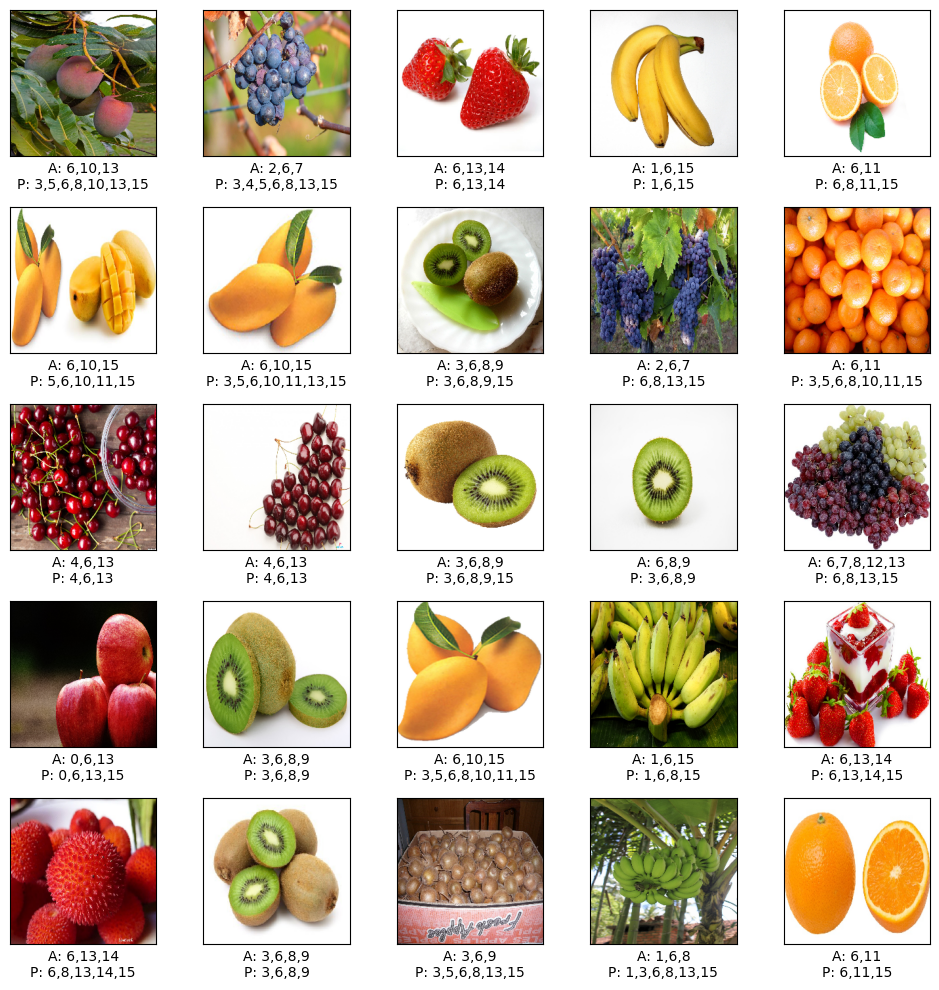

In [55]:
# Test model
test_loss, test_acc = model.evaluate(test_data, test_labels)
print("Test accuracy: ", test_acc)

# Predict
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels = [classes[label] for label in predicted_labels]

# Plot
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.tight_layout()
    plt.imshow(test_data[i], cmap=plt.cm.binary)
    actual_labels = ','.join([str(idx) for idx, val in enumerate(test_labels[i]) if val == 1])
    predicted_labels_str = ','.join([str(idx) for idx, val in enumerate(predictions[i]) if val > 0.8])
    plt.xlabel(f"A: {actual_labels}\nP: {predicted_labels_str}")
plt.show()